In [19]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)

In [21]:
Q1 = df['W_LEV_AVG'].quantile(0.25)
Q3 = df['W_LEV_AVG'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['W_LEV_AVG'] >= Q1 - 1.5 * IQR) & (df['W_LEV_AVG'] <= Q3 + 1.5 * IQR)]
df

,W_LEV_AVG
DATE,
2013-10-01 07:00:00,0.4129
2013-10-01 07:10:00,0.4528
2013-10-01 07:20:00,0.4901
2013-10-01 07:30:00,0.5079
2013-10-01 07:40:00,0.5468
...,...
2023-12-31 23:10:00,0.3508
2023-12-31 23:20:00,0.4242
2023-12-31 23:30:00,0.4790


In [22]:
# Extract time components
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['hour'] = df.index.hour
df['minute'] = df.index.minute

In [23]:
# Create hour_of_day feature (decimal hours)
df['hour_of_day'] = df['hour'] + df['minute']/60

# Create cyclical features for annual, monthly, weekly, and daily patterns
# For day of year
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# For month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# For day of month
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# For day of week
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# For hour of day (24-hour cycle)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

In [24]:
# Lunar cycle features (approximation)
# Lunar day (24.84 hours)
hours_since_epoch = (df.index - pd.Timestamp('1970-01-01')).total_seconds() / 3600
df['lunar_day_sin'] = np.sin(2 * np.pi * hours_since_epoch / 24.84)
df['lunar_day_cos'] = np.cos(2 * np.pi * hours_since_epoch / 24.84)

# Lunar month (29.53 days)
days_since_epoch = hours_since_epoch / 24
df['lunar_month_sin'] = np.sin(2 * np.pi * days_since_epoch / 29.53)
df['lunar_month_cos'] = np.cos(2 * np.pi * days_since_epoch / 29.53)

# Tidal components (semidiurnal cycle ~12.42 hours)
df['semidiurnal_sin'] = np.sin(2 * np.pi * hours_since_epoch / 12.42)
df['semidiurnal_cos'] = np.cos(2 * np.pi * hours_since_epoch / 12.42)

In [26]:
# Lagged features based on 10-minute intervals
# Short-term lags (recent hours)
for lag in [1, 2, 3, 6, 12, 18]:  # 10min to 3hrs
    df[f'W_LEV_AVG_lag_{lag*10}m'] = df['W_LEV_AVG'].shift(lag)

# Medium-term lags (hours to day)
for lag in [36, 72, 144]:  # 6hrs, 12hrs, 24hrs (1 day)
    df[f'W_LEV_AVG_lag_{lag//6}h'] = df['W_LEV_AVG'].shift(lag)

In [27]:
# Tidal cycle based lags
# ~12.42 hours for semidiurnal cycle (typical tidal period)
semidiurnal_lag = int(12.42 * 6)  # ~74-75 10-minute intervals
df[f'W_LEV_AVG_lag_tidal'] = df['W_LEV_AVG'].shift(semidiurnal_lag)

# ~24.84 hours for complete lunar day
lunar_day_lag = int(24.84 * 6)  # ~149 10-minute intervals
df[f'W_LEV_AVG_lag_lunar_day'] = df['W_LEV_AVG'].shift(lunar_day_lag)

# 3-day lag (matches forecast horizon)
three_day_lag = 3 * 24 * 6  # 3 days × 24 hours × 6 intervals per hour
df[f'W_LEV_AVG_lag_3d'] = df['W_LEV_AVG'].shift(three_day_lag)

# Moving averages (in number of 10-minute intervals)
# Convert windows from hours to number of 10-minute intervals
for window_hours in [3, 6, 12, 24, 48]:
    window_intervals = window_hours * 6  # 6 intervals per hour
    df[f'W_LEV_AVG_ma_{window_hours}h'] = df['W_LEV_AVG'].rolling(window=window_intervals).mean()

# First and second order differences
df['W_LEV_AVG_diff1'] = df['W_LEV_AVG'].diff()
df['W_LEV_AVG_diff2'] = df['W_LEV_AVG_diff1'].diff()

# Rate of change features (useful for high-frequency data)
df['W_LEV_AVG_roc_10m'] = df['W_LEV_AVG_diff1']  # Rate of change over 10 minutes
df['W_LEV_AVG_roc_30m'] = df['W_LEV_AVG'] - df['W_LEV_AVG'].shift(3)  # 30 minute rate
df['W_LEV_AVG_roc_1h'] = df['W_LEV_AVG'] - df['W_LEV_AVG'].shift(6)  # 1 hour rate

# Statistical features over different windows
for window_hours in [3, 6, 12, 24]:
    window_intervals = window_hours * 6
    df[f'W_LEV_AVG_std_{window_hours}h'] = df['W_LEV_AVG'].rolling(window=window_intervals).std()
    df[f'W_LEV_AVG_min_{window_hours}h'] = df['W_LEV_AVG'].rolling(window=window_intervals).min()
    df[f'W_LEV_AVG_max_{window_hours}h'] = df['W_LEV_AVG'].rolling(window=window_intervals).max()
    # Range within window
    df[f'W_LEV_AVG_range_{window_hours}h'] = df[f'W_LEV_AVG_max_{window_hours}h'] - df[f'W_LEV_AVG_min_{window_hours}h']

In [28]:
# Create target variable for 3-day forecasting (432 10-minute intervals)
forecast_intervals = 3 * 24 * 6  # 3 days * 24 hours * 6 intervals per hour
df['target'] = df['W_LEV_AVG'].shift(-forecast_intervals)

# Drop NaN values resulting from lag, rolling operations, and target creation
df = df.dropna()

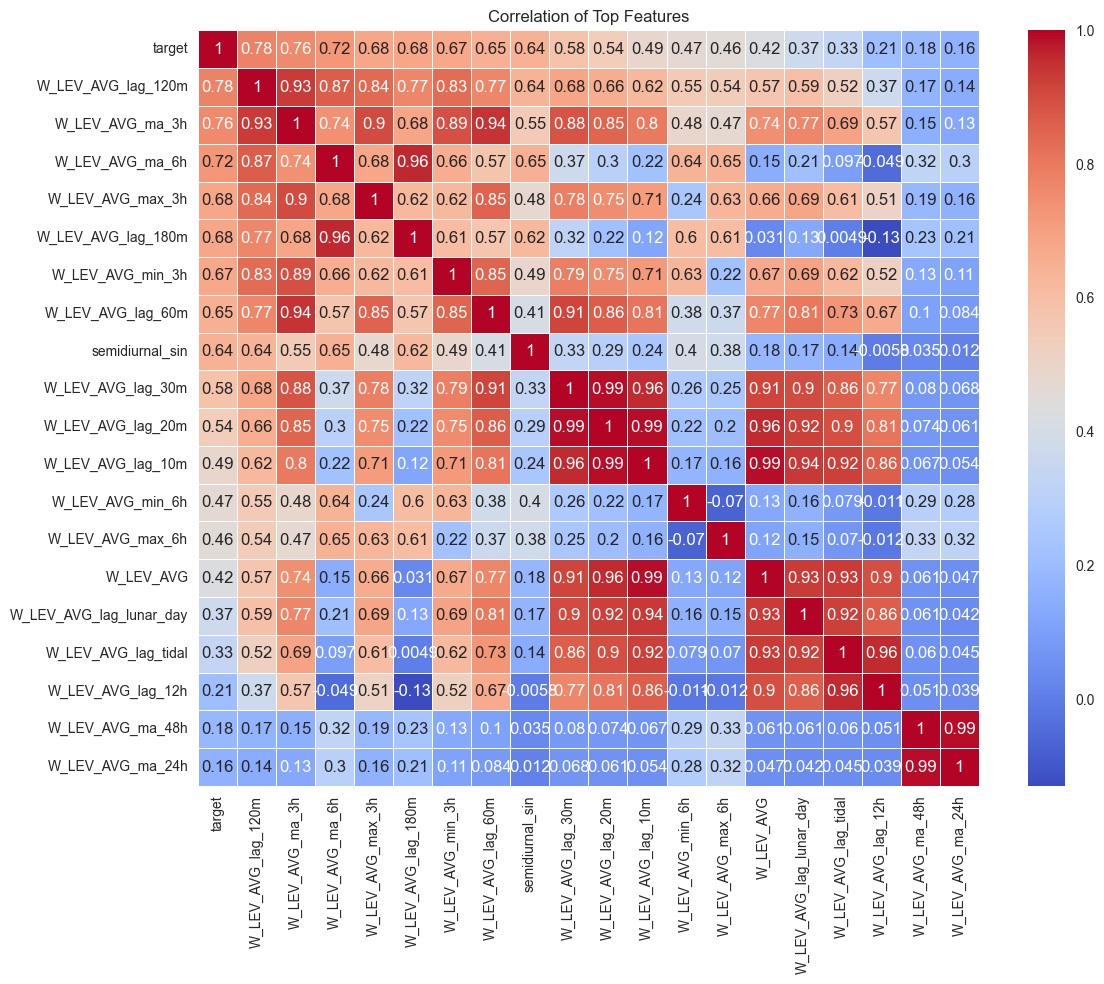

In [29]:
# Visualize the feature correlation with target
plt.figure(figsize=(12, 10))
corr = df.corr()['target'].sort_values(ascending=False)
top_features = corr.iloc[:20].index
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Top Features')
plt.tight_layout()

In [ ]:
# Reset index to make date a column (for PyCaret)
df_pycaret = df.reset_index()

In [35]:
df_pycaret_test = df_pycaret[:20000]

In [38]:
# Setup PyCaret regression with correct parameters
setup_pycaret = setup(
    data=df_pycaret_test,
    target='target',
    train_size=0.8,
    session_id=42,
    use_gpu=True,  # Set to False if GPU not available
    ignore_features=['index', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'day_of_year'],
    preprocess=True,
    data_split_shuffle=False,  # Important for time series data
    fold=5
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(20000, 65)"
4,Transformed data shape,"(20000, 60)"
5,Transformed train set shape,"(16000, 60)"
6,Transformed test set shape,"(4000, 60)"
7,Ignore features,8
8,Numeric features,56
9,Date features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [39]:
# Compare top models
best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:14:48
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.2315,0.1283,0.3206,0.7697,0.1550,1.4939,0.0460
ridge,Ridge Regression,0.2622,0.1834,0.3828,0.6625,0.1710,1.9644,0.0440
br,Bayesian Ridge,0.2565,0.1849,0.3834,0.6604,0.1694,1.8973,0.0680
et,Extra Trees Regressor,0.2369,0.1844,0.3641,0.6586,0.1552,1.1476,2.4620
huber,Huber Regressor,0.3212,0.1950,0.4183,0.6467,0.2062,2.3301,0.4340
lr,Linear Regression,0.2615,0.1937,0.3916,0.6436,0.1723,1.9957,0.0700
ada,AdaBoost Regressor,0.3404,0.2329,0.4709,0.5753,0.2308,1.6411,4.7920
gbr,Gradient Boosting Regressor,0.2864,0.2413,0.4043,0.5451,0.1786,1.3924,16.3880
knn,K Neighbors Regressor,0.2509,0.2572,0.4479,0.5181,0.1615,1.6274,0.1000
lightgbm,Light Gradient Boosting Machine,0.2864,0.2730,0.4089,0.4813,0.1640,1.6929,1.4720


In [40]:
# Select best model and fine-tune
best_model = create_model('omp')
tuned_model = tune_model(best_model, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1714,0.0441,0.2099,0.9188,0.1289,1.7402
1,0.1894,0.0535,0.2314,0.9149,0.1359,1.3320
2,0.2122,0.0651,0.2552,0.8739,0.1525,1.1278
3,0.3567,0.4068,0.6378,0.2846,0.2028,1.3067
4,0.2275,0.0721,0.2684,0.8565,0.1547,1.9630
Mean,0.2315,0.1283,0.3206,0.7697,0.1550,1.4939
Std,0.0655,0.1396,0.1599,0.2437,0.0258,0.3085


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1892,0.0535,0.2314,0.9013,0.1359,1.9615
1,0.1737,0.0460,0.2145,0.9268,0.1251,1.4000
2,0.2029,0.0623,0.2496,0.8794,0.1481,1.0924
3,0.3721,0.4982,0.7058,0.1240,0.2053,1.3304
4,0.3007,0.2539,0.5038,0.4943,0.2180,3.2388
Mean,0.2477,0.1828,0.3810,0.6652,0.1665,1.8046
Std,0.0764,0.1757,0.1939,0.3138,0.0378,0.7717


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


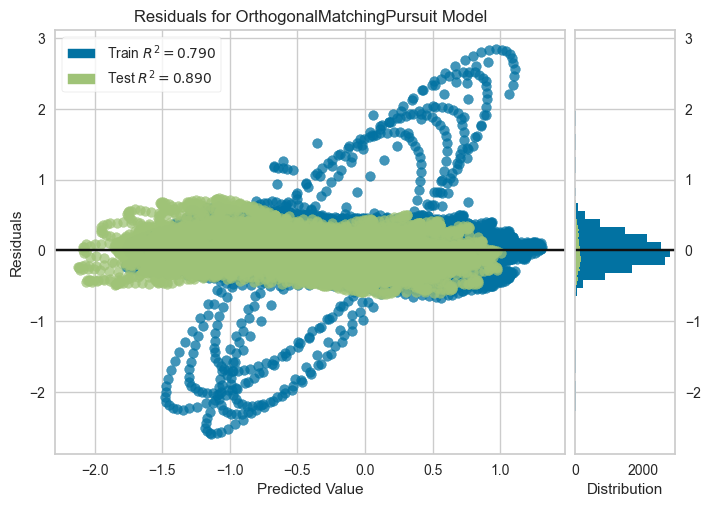

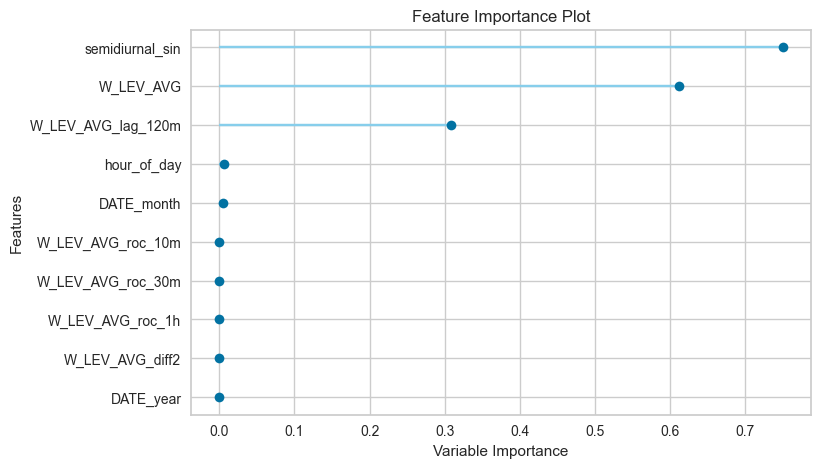

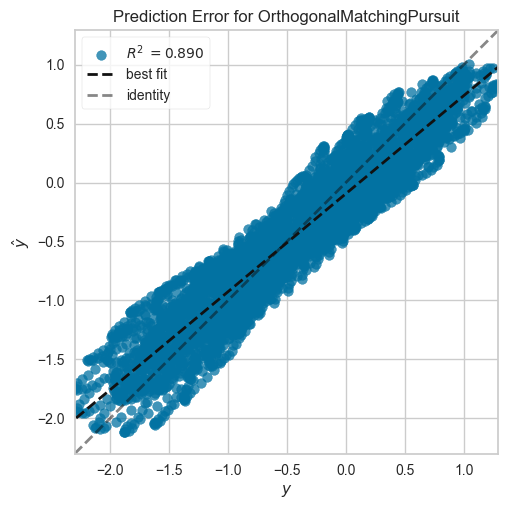

In [ ]:
# Create plots to evaluate model
plot_model(tuned_model, plot='residuals')
plot_model(tuned_model, plot='feature')
plot_model(tuned_model, plot='error')

In [42]:
# Finalize model (train on entire dataset)
final_model = finalize_model(tuned_model)

In [43]:
# Save model
save_model(final_model, 'tide_forecast_10min_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['DATE'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['W_LEV_AVG', 'hour_of_day',
                                              'day_of_year_sin',
                                              'day_of_year_cos', 'month_sin',
                                              'month_cos', 'day_sin', 'day_cos',
                                              'day_of_week_sin',
                                              'day_of_week_cos', 'hour_sin',
                                              '...
                                              'W_LEV_AVG_lag_120m',
                                              'W_LEV_AVG_lag_180m',
                                              'W_LEV_AVG_lag_6h',
                                              'W_LE

In [48]:
# Create a dataframe for future dates (next 3 days)
last_date = df.index.max()
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(minutes=10), 
                                 periods=forecast_intervals, 
                                 freq='10min')

# For demonstration: Create prediction features by reusing the most recent features
# In practice, you would need to properly generate these features for future dates
last_features = df_pycaret.drop(['target'], axis=1).iloc[-1:].copy()
future_features = pd.concat([last_features] * forecast_intervals, ignore_index=True)

# Update the date column with future dates
future_features['index'] = prediction_dates

# Make predictions using PyCaret
predictions = predict_model(final_model, data=future_features)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({
    'date': prediction_dates,
    'predicted_W_LEV_AVG': predictions['prediction_label'].values
})

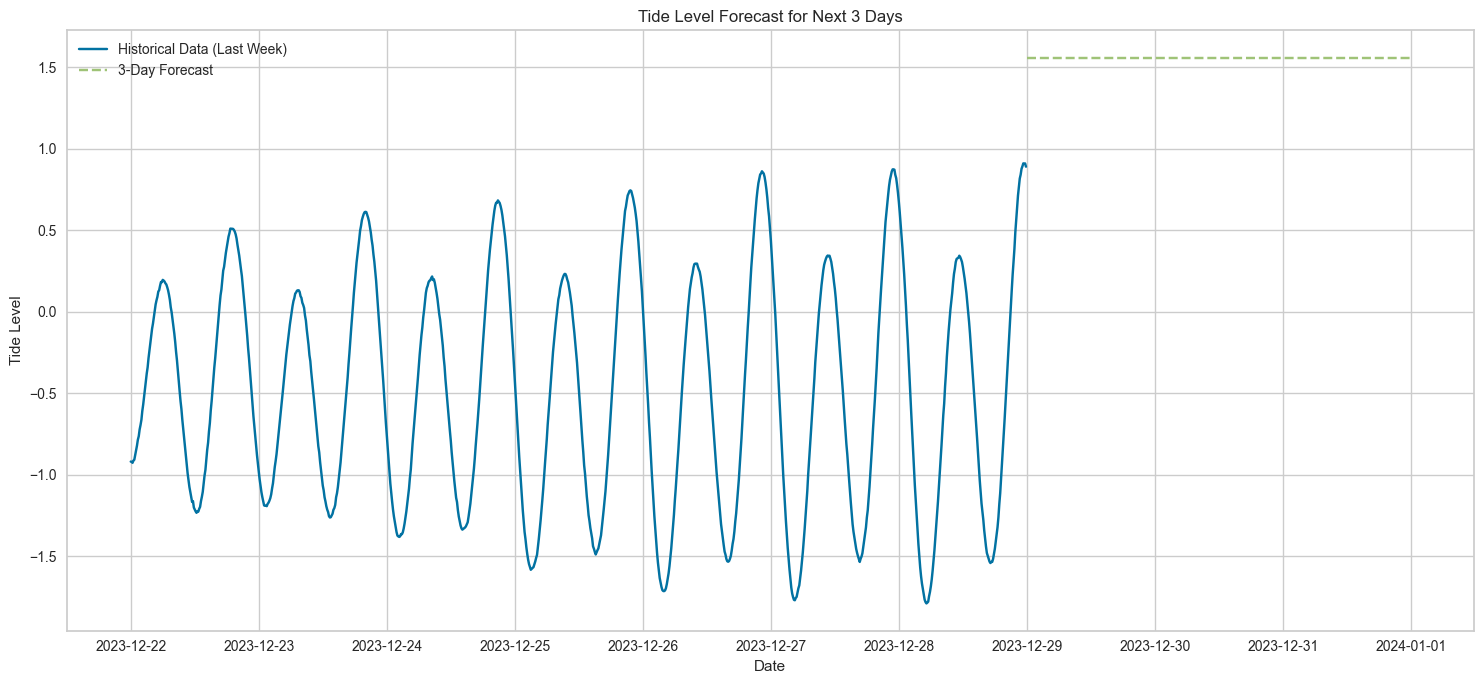

In [49]:
# Plot the historical data and predictions
plt.figure(figsize=(15, 7))
plt.plot(df.index[-7*24*6:], df['W_LEV_AVG'][-7*24*6:], label='Historical Data (Last Week)')
plt.plot(predictions_df['date'], predictions_df['predicted_W_LEV_AVG'], label='3-Day Forecast', linestyle='--')
plt.title('Tide Level Forecast for Next 3 Days')
plt.ylabel('Tide Level')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Print predicted high and low tides
high_tides = predictions_df.sort_values('predicted_W_LEV_AVG', ascending=False).head(6)
low_tides = predictions_df.sort_values('predicted_W_LEV_AVG').head(6)

print("\nPredicted High Tides for Next 3 Days:")
print(high_tides[['date', 'predicted_W_LEV_AVG']])

print("\nPredicted Low Tides for Next 3 Days:")
print(low_tides[['date', 'predicted_W_LEV_AVG']])


Predicted High Tides for Next 3 Days:
                   date  predicted_W_LEV_AVG
0   2023-12-29 00:00:00             1.557403
284 2023-12-30 23:20:00             1.557403
295 2023-12-31 01:10:00             1.557403
294 2023-12-31 01:00:00             1.557403
293 2023-12-31 00:50:00             1.557403
292 2023-12-31 00:40:00             1.557403

Predicted Low Tides for Next 3 Days:
                   date  predicted_W_LEV_AVG
0   2023-12-29 00:00:00             1.557403
294 2023-12-31 01:00:00             1.557403
293 2023-12-31 00:50:00             1.557403
292 2023-12-31 00:40:00             1.557403
291 2023-12-31 00:30:00             1.557403
290 2023-12-31 00:20:00             1.557403
